In [66]:
import numpy as np
import pandas as pd

df = pd.read_csv("./out.csv", dtype={"article_id": str})
print(df.shape)
df.head()

(671674, 8)


,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,bought
0,2020-09-14,0008968c0d451dbc5a9968da03196fe20051965edde741...,893059004,0.035576,2,2020-09-14,2020-09-14,1
1,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,902802002,0.033881,2,2020-09-03,2020-09-03,1
2,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000007,0.050831,2,2020-09-03,2020-09-03,1
3,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,918292001,0.042356,2,2020-09-03,2020-09-03,1
4,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000001,0.050831,2,2020-09-03,2020-09-03,1


In [67]:
df["t_dat"] = pd.to_datetime(df["t_dat"])
df["t_dat"].max()

Timestamp('2020-09-22 00:00:00')

In [68]:
active_articles = df.groupby("article_id")["t_dat"].max().reset_index()
active_articles = active_articles[active_articles["t_dat"] >= "2019-09-01"].reset_index()
active_articles.shape

(9225, 3)

In [70]:
df = df[df["article_id"].isin(active_articles["article_id"])].reset_index(drop=True)
df.shape

(671674, 8)

In [71]:
df["week"] = (df["t_dat"].max() - df["t_dat"]).dt.days // 7
df["week"].value_counts()

2    221101
1    216090
0    202700
3     31783
Name: week, dtype: int64

In [72]:
from sklearn.preprocessing import LabelEncoder


article_ids = np.concatenate([["placeholder"], np.unique(df["article_id"].values)])

le_article = LabelEncoder()
le_article.fit(article_ids)
df["article_id"] = le_article.transform(df["article_id"])

In [73]:
WEEK_HIST_MAX = 5

def create_dataset(df, week):
    hist_df = df[(df["week"] > week) & (df["week"] <= week + WEEK_HIST_MAX)]
    hist_df = hist_df.groupby("customer_id").agg({"article_id": list, "week": list}).reset_index()
    hist_df.rename(columns={"week": 'week_history'}, inplace=True)
    
    target_df = df[df["week"] == week]
    target_df = target_df.groupby("customer_id").agg({"article_id": list}).reset_index()
    target_df.rename(columns={"article_id": "target"}, inplace=True)
    target_df["week"] = week
    
    return target_df.merge(hist_df, on="customer_id", how="left")

val_weeks = [0]
train_weeks = [1, 2, 3, 4]


val_df = pd.concat([create_dataset(df, w) for w in val_weeks]).reset_index(drop=True)
train_df = pd.concat([create_dataset(df, w) for w in train_weeks]).reset_index(drop=True)
train_df.shape, val_df.shape

((155210, 5), (67007, 5))

In [74]:
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm

class HMDataset(Dataset):
    def __init__(self, df, seq_len, is_test=False):
        self.df = df.reset_index(drop=True)
        self.seq_len = seq_len
        self.is_test = is_test
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        if self.is_test:
            target = torch.zeros(2).float()
        else:
            target = torch.zeros(len(article_ids)).float()
            for t in row.target:
                target[t] = 1.0
            
        article_hist = torch.zeros(self.seq_len).long()
        week_hist = torch.ones(self.seq_len).float()
        
        
        if isinstance(row.article_id, list):
            if len(row.article_id) >= self.seq_len:
                article_hist = torch.LongTensor(row.article_id[-self.seq_len:])
                week_hist = (torch.LongTensor(row.week_history[-self.seq_len:]) - row.week)/WEEK_HIST_MAX/2
            else:
                article_hist[-len(row.article_id):] = torch.LongTensor(row.article_id)
                week_hist[-len(row.article_id):] = (torch.LongTensor(row.week_history) - row.week)/WEEK_HIST_MAX/2
                
        return article_hist, week_hist, target
    
HMDataset(val_df, 64)[1]

(tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 8256, 7700,
         7821,  997,  884, 6807]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 0.2000, 0.2000, 0.2000, 0.1000, 0

In [75]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 6:
        lr = 1e-3
    elif epoch < 9:
        lr = 1e-4
    else:
        lr = 1e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-08)
    return optimizer

In [76]:
import torch.nn as nn
import torch.nn.functional as F

class HMModel(nn.Module):
    def __init__(self, article_shape):
        super(HMModel, self).__init__()
        
        self.article_emb = nn.Embedding(article_shape[0], embedding_dim=article_shape[1])
        
        self.article_likelihood = nn.Parameter(torch.zeros(article_shape[0]), requires_grad=True)
        self.top = nn.Sequential(nn.Conv1d(3, 32, kernel_size=1), nn.LeakyReLU(),
                                 nn.Conv1d(32, 8, kernel_size=1), nn.LeakyReLU(),
                                 nn.Conv1d(8, 1, kernel_size=1))
        
    def forward(self, inputs):
        article_hist, week_hist = inputs[0], inputs[1]
        x = self.article_emb(article_hist)
        x = F.normalize(x, dim=2)
        
        x = x@F.normalize(self.article_emb.weight).T
        
        x, indices = x.max(axis=1)
        x = x.clamp(1e-3, 0.999)
        x = -torch.log(1/x - 1)
        
        max_week = week_hist.unsqueeze(2).repeat(1, 1, x.shape[-1]).gather(1, indices.unsqueeze(1).repeat(1, week_hist.shape[1], 1))
        max_week = max_week.mean(axis=1).unsqueeze(1)
        
        x = torch.cat([x.unsqueeze(1), max_week,
                       self.article_likelihood[None, None, :].repeat(x.shape[0], 1, 1)], axis=1)
        
        x = self.top(x).squeeze(1)
        return x
    
    
model = HMModel((len(le_article.classes_), 512))
model = model.cuda()

In [77]:
import sys

def calc_map(topk_preds, target_array, k=12):
    metric = []
    tp, fp = 0, 0
    
    for pred in topk_preds:
        if target_array[pred]:
            tp += 1
            metric.append(tp/(tp + fp))
        else:
            fp += 1
            
    return np.sum(metric) / min(k, target_array.sum())

def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()


def validate(model, val_loader, k=12):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    maps = []
    
    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            logits = model(inputs)

            _, indices = torch.topk(logits, k, dim=1)

            indices = indices.detach().cpu().numpy()
            target = target.detach().cpu().numpy()

            for i in range(indices.shape[0]):
                maps.append(calc_map(indices[i], target[i]))
        
    
    return np.mean(maps)

SEQ_LEN = 16

BS = 256
NW = 8

val_dataset = HMDataset(val_df, SEQ_LEN)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Train and validate

In [78]:
def dice_loss(y_pred, y_true):
    y_pred = y_pred.sigmoid()
    intersect = (y_true*y_pred).sum(axis=1)
    
    return 1 - (intersect/(intersect + y_true.sum(axis=1) + y_pred.sum(axis=1))).mean()


def train(model, train_loader, val_loader, epochs):
    np.random.seed(SEED)
    
    optimizer = get_optimizer(model)
    scaler = torch.cuda.amp.GradScaler()

    criterion = torch.nn.BCEWithLogitsLoss()
    
    for e in range(epochs):
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)
        
        lr = adjust_lr(optimizer, e)
        
        loss_list = []

        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                logits = model(inputs)
                loss = criterion(logits, target) + dice_loss(logits, target)
            
            
            #loss.backward()
            scaler.scale(loss).backward()
            #optimizer.step()
            scaler.step(optimizer)
            scaler.update()
            
            loss_list.append(loss.detach().cpu().item())
            
            avg_loss = np.round(100*np.mean(loss_list), 4)

            tbar.set_description(f"Epoch {e+1} Loss: {avg_loss} lr: {lr}")
            
        val_map = validate(model, val_loader)

        log_text = f"Epoch {e+1}\nTrain Loss: {avg_loss}\nValidation MAP: {val_map}\n"
            
        print(log_text)

    return model


MODEL_NAME = "exp001"
SEED = 0


train_dataset = HMDataset(train_df, SEQ_LEN)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)

model = train(model, train_loader, val_loader, epochs=10)

100%|██████████| 262/262 [00:13<00:00, 18.98it/s]
Epoch 1
Train Loss: 162.0504
Validation MAP: 0.01913975560099177

100%|██████████| 262/262 [00:13<00:00, 19.66it/s]
Epoch 2
Train Loss: 101.626
Validation MAP: 0.021943501180587376

100%|██████████| 262/262 [00:13<00:00, 19.14it/s]
Epoch 3
Train Loss: 100.0769
Validation MAP: 0.023743176796660676

100%|██████████| 262/262 [00:13<00:00, 20.02it/s]
Epoch 4
Train Loss: 99.989
Validation MAP: 0.023927136087089036

100%|██████████| 262/262 [00:12<00:00, 20.25it/s]
Epoch 5
Train Loss: 99.9249
Validation MAP: 0.02398370118873548

100%|██████████| 262/262 [00:13<00:00, 19.92it/s]
Epoch 6
Train Loss: 99.8683
Validation MAP: 0.024025876435039954

100%|██████████| 262/262 [00:12<00:00, 20.44it/s]
Epoch 7
Train Loss: 99.8473
Validation MAP: 0.024013123671055243

100%|██████████| 262/262 [00:13<00:00, 19.49it/s]
Epoch 8
Train Loss: 99.8443
Validation MAP: 0.024016155945622574

100%|██████████| 262/262 [00:13<00:00, 19.70it/s]
Epoch 9
Train Loss: 99.

### Final data

In [79]:
test_df = pd.read_csv('./h-and-m-personalized-fashion-recommendations/sample_submission.csv').drop("prediction", axis=1)
print(test_df.shape)
test_df.head()

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [80]:
def create_test_dataset(test_df):
    week = -1
    test_df["week"] = week
    
    hist_df = df[(df["week"] > week) & (df["week"] <= week + WEEK_HIST_MAX)]
    hist_df = hist_df.groupby("customer_id").agg({"article_id": list, "week": list}).reset_index()
    hist_df.rename(columns={"week": 'week_history'}, inplace=True)
    
    
    return test_df.merge(hist_df, on="customer_id", how="left")

test_df = create_test_dataset(test_df)
test_df.head()

,customer_id,week,article_id,week_history
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1,[604],[2]
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-1,NaN,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1,[2953],[1]
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-1,NaN,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-1,NaN,NaN


In [81]:
test_df["article_id"].isnull().mean()

0.865299785711162

In [82]:
test_ds = HMDataset(test_df, SEQ_LEN, is_test=True)
test_loader = DataLoader(test_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)


def inference(model, loader, k=12):
    model.eval()
    
    tbar = tqdm(loader, file=sys.stdout)
    
    preds = []
    
    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            logits = model(inputs)

            _, indices = torch.topk(logits, k, dim=1)

            indices = indices.detach().cpu().numpy()
            target = target.detach().cpu().numpy()

            for i in range(indices.shape[0]):
                preds.append(" ".join(list(le_article.inverse_transform(indices[i]))))
        
    
    return preds


test_df["prediction"] = inference(model, test_loader)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 5360/5360 [07:32<00:00, 11.84it/s]


In [83]:
test_df.head()

,customer_id,week,article_id,week_history,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1,[604],[2],568601043 915526001 751471001 751471043 915529...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-1,NaN,NaN,915526001 751471001 751471043 915529003 898694...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1,[2953],[1],794321007 915526001 751471001 751471043 915529...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-1,NaN,NaN,915526001 751471001 751471043 915529003 898694...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-1,NaN,NaN,915526001 751471001 751471043 915529003 898694...


In [122]:
filtered_df = test_df[['customer_id', 'prediction']]
filtered_df.head()
filtered_df.tail()

,customer_id,prediction
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,557599022 804992033 720125039 791587007 740922...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,915526001 751471001 751471043 915529003 898694...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,762846027 689365050 884081001 915526001 794819...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,915526001 751471001 751471043 915529003 898694...
1371979,ffffd9ac14e89946416d80e791d064701994755c3ab686...,915526001 751471001 751471043 915529003 898694...


In [94]:
articles=pd.read_csv("./h-and-m-personalized-fashion-recommendations/articles.csv")

In [126]:
# 첫번째 고객 
prediction_str= filtered_df['prediction'].iloc[0]
#print(prediction_str)
# 1371976번째 고객 
# prediction_str_2 = filtered_df['prediction'].iloc[1371975]
#print(prediction_str)
predicted_article_ids = list(map(int, prediction_str.split()))
matching_articles = articles[articles['article_id'].isin(predicted_article_ids)]
matching_articles


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
3091,448509014,448509,Perrie Slim Mom Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,72,Blue,...,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,"5-pocket, ankle-length jeans in washed, sturdy..."
16023,568601043,568601,Mariette Blazer,264,Blazer,Garment Upper body,1010026,Other structure,93,Dark Green,...,Suit,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1008,Dressed,Fitted jacket in woven fabric with notch lapel...
42626,673677002,673677,Henry polo. (1),252,Sweater,Garment Upper body,1010016,Solid,9,Black,...,Knitwear,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1003,Knitwear,"Jumper in a soft, fine knit with a ribbed polo..."
67522,751471001,751471,Pluto RW slacks (1),272,Trousers,Garment Lower body,1010016,Solid,9,Black,...,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Ankle-length cigarette trousers in a stretch w...
67543,751471043,751471,Pluto RW slacks (1),272,Trousers,Garment Lower body,1010004,Check,9,Black,...,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Ankle-length cigarette trousers in a stretch w...
71110,762846031,762846,Lucy blouse,259,Shirt,Garment Upper body,1010016,Solid,93,Dark Green,...,Blouse,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1010,Blouses,Long-sleeved blouse in woven fabric with a col...
94674,863595006,863595,Baraboom throw-on,245,Cardigan,Garment Upper body,1010016,Solid,9,Black,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Long cardigan in a soft, fine knit containing ..."
101367,896152002,896152,Amelie,255,T-shirt,Garment Upper body,1010016,Solid,9,Black,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Top in a soft, fine knit containing some wool ..."
101718,898694001,898694,Jasba jersey shacket,264,Blazer,Garment Upper body,1010010,Melange,12,Light Beige,...,Suit jacket,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1008,Dressed,"Shirt jacket in jersey with a collar, buttons ..."
103793,915526001,915526,Nika vest,252,Sweater,Garment Upper body,1010016,Solid,11,Off White,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Relaxed-fit slipover in a soft, rib-knit cotto..."


In [127]:
import matplotlib.pyplot as plt
path = "../input/h-and-m-personalized-fashion-recommendations/images"
rcmnds_img=matching_articles

def article_recommend_img():
    fig = plt.figure(figsize=(20, 10))
    for i, item in enumerate(rcmnds_img['article_id']):
        item = '0' + str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        ax = fig.add_subplot(1, 12, i+1)  
        ax.imshow(image)
        ax.axis('off')  

    plt.show()  

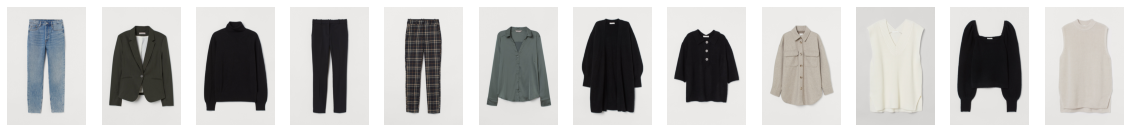

In [128]:
article_recommend_img()